---
---

# 1. Setup

---
---

### General Imports

In [ ]:
import os
import json
import random
import ast

import numpy as np
import pandas as pd

from google.colab import drive
import tensorflow as tf
import nltk

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from spotipy.oauth2 import SpotifyClientCredentials
from ipywidgets import SelectMultiple, VBox, Button, Label, Layout, Output, HBox, Image, HTML, Text
from IPython.display import display

### Mount the Drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/ca4015_assignment4")

---
---

# 2. Read in Data

---
---

### Read in the full dataset

In [ ]:
df = pd.read_csv("data/processed_data/original_and_spotify_data (1).csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.sample(5)

,userID,artistID,artistWeight,friendID,artistName,tagID,timestamp,tagValue,spotifyName,imageUrl,genres,spotifyUrl
1812056,1164,6150,2862.0,59.0,Tangerine Dream,7588.0,2011-02-28 23:00:00.000,ladytronica,Tangerine Dream,https://i.scdn.co/image/0f3f987d35781d0de0dd86...,"['art rock', 'berlin school', 'krautrock', 'pr...",https://open.spotify.com/artist/1BGN1IdyiSR0ZY...
1600474,545,3094,316.0,927.0,The Exies,79.0,2009-01-31 23:00:00.000,alternative,The Exies,https://i.scdn.co/image/2b8a90d3d9e5affc137ccb...,"['alternative metal', 'hard alternative', 'nu ...",https://open.spotify.com/artist/5V5NZ8y72BgxpB...
20090,1850,55,760.0,1002.0,Kylie Minogue,210.0,2009-11-30 23:00:00.000,00s,Kylie Minogue,https://i.scdn.co/image/471aae2bc20f974dbf573a...,"['australian dance', 'australian pop', 'dance ...",https://open.spotify.com/artist/4RVnAU35WRWra6...
1085858,25,907,271.0,1308.0,Timbaland,NaN,NaN,NaN,Timbaland,https://i.scdn.co/image/71e2c7a1026d3a2397ae7e...,"['dance pop', 'hip hop', 'hip pop', 'pop', 'po...",https://open.spotify.com/artist/5Y5TRrQiqgUO4S...
425877,1104,292,521.0,1663.0,Christina Aguilera,130.0,2010-06-30 22:00:00.000,female vocalists,Christina Aguilera,https://i.scdn.co/image/e3ea6d2340bba0d93450a8...,"['dance pop', 'pop', 'pop dance', 'pop rap', '...",https://open.spotify.com/artist/1l7ZsJRRS8wlW3...


### Get a subset of this dataset related to the artist

In [ ]:
artists = df[["artistID", "artistName", "imageUrl", "spotifyUrl", "genres"]] \
.drop_duplicates().dropna(subset=["artistName"]) \
.sort_values("artistID").reset_index(drop=True)

artists["genres"] = artists["genres"].apply(ast.literal_eval)
artists["genre"] = artists["genres"].apply(lambda x: x[0] if len(x) > 0 else None)

### Get a subset of this dataset related to the data on users listening to artists

The main data we are interested in is the listening data.  
Each row represents the amount of time a user listens to a given artist.

In [ ]:
listening = df[["userID", "artistID", "artistWeight"]].drop_duplicates().dropna().astype(int).sort_values(["userID", "artistID"]).reset_index(drop=True)
listening

,userID,artistID,artistWeight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [ ]:
num_users = listening["userID"].max() + 1
num_artists = listening["artistID"].max() + 1

print("Number of unique users:", num_users)
print("Number of unique artists:", num_artists)
print(f"Data density: {len(listening) / (num_users * num_artists):.2%}")

Number of unique users: 2101
Number of unique artists: 18746
Data density: 0.24%


---
---
# 3. Softmax Model
---
---


Out model is built using the Tensorflow library. 
Its architecture is as follows:
- Embedding layer which takes the one-hot vector representing the user and turns it into a single 64-dimensional vector.  
- Two fully connected hidden layers.  
- A final fully connected layer with a softmax activation. This gives us a predicted probablity that the user will like each artist.  

We also incorporate several additions to help the model train:
- **Dropout**: This randomly sets a portion of the values to 0. This helps the model to not rely too heavily on any one value sine they are not guaranteed to be there.  
- **Batch normalisation**: This normalises the values using the mean and variance of the batch. This helps to stabilise and speed up network training.  
- **Regularisation**: This penalises the magnitude of the weights learned by the model, which encourages it to keep weights small. This helps reduce overfitting on the training data and improves generalisability to unseen examples.  

### Build the model

In [ ]:
embedding_size = 64

In [ ]:
def build_model(num_artists, embedding_size=64, hidden_size=64, dropout=0.2, batch_norm=True, regularisation=None):
    input = tf.keras.layers.Input((num_artists,))

    # Embedding layer
    x = tf.keras.layers.Dense(embedding_size, use_bias=False)(input)

    # First hidden layer
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(hidden_size, use_bias=not batch_norm, kernel_regularizer=regularisation)(x)
    
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
      
    x = tf.keras.layers.Activation("relu")(x)

    # Second hidden layer
    if dropout > 0:
       x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(hidden_size, use_bias=not batch_norm, kernel_regularizer=regularisation)(x)

    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation("relu")(x)
    
    # Output layer
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(num_artists)(x)
    x = tf.keras.layers.Softmax()(x)
    
    return tf.keras.Model(input, x)

In [ ]:
model = build_model(num_artists, embedding_size, dropout=0.2, batch_norm=True, regularisation=None)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18746)]           0         
_________________________________________________________________
dense (Dense)                (None, 64)                1199744   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

### Train the model

For the training data, we group the data by the user, generating a list of artists they have listened to. We then turn this list into a one-hot vector, which is a vector of 0s of length $num\_artists$ with 1s at the index corresponding to each artists the user has listened to.  
We then mask out a number of the artists from the vector, and train the model to predict the original vector (normalised to sum to 1). 

Example:  
There are 10 artists in the dataset.  
The user has listened to artists [2, 5, 7].  
The corresponding one-hot vector is: [0, 0, 1, 0, 0, 1, 0, 1, 0, 0].  
We randomly mask out artist 2: [0, 0, **0**, 0, 0, 1, 0, 1, 0, 0].  

Our (input, target) pair for the model in this case is:  
- input: [0, 0, **0**, 0, 0, 1, 0, 1, 0, 0]  
- target: [0, 0, 0.33, 0, 0, 0.33, 0, 0.33, 0, 0]  

In [ ]:
user_artists = listening.groupby("userID")["artistID"].apply(list)
user_artists

userID
2       [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6...
3       [101, 102, 103, 104, 105, 106, 107, 108, 109, ...
4       [51, 53, 64, 65, 70, 72, 77, 151, 152, 153, 15...
5       [53, 154, 173, 182, 190, 194, 195, 196, 197, 1...
6       [77, 239, 240, 241, 242, 243, 244, 245, 246, 2...
                              ...                        
2095    [1109, 1126, 2312, 2331, 2952, 4972, 6961, 842...
2096    [88, 154, 163, 166, 172, 173, 187, 190, 197, 1...
2097    [56, 59, 72, 81, 154, 159, 163, 166, 199, 203,...
2099    [138, 407, 748, 1835, 1943, 1945, 1969, 2605, ...
2100    [3, 6, 12, 28, 47, 837, 841, 1109, 1111, 1134,...
Name: artistID, Length: 1892, dtype: object

In [ ]:
def one_hot_encoder(num_artists):
    def encode(user_artists):
        one_hots = []
        for artists in user_artists:
            one_hots.append(tf.keras.utils.to_categorical(artists, num_artists).sum(axis=0))

        return np.vstack(one_hots)

    return encode

In [ ]:
oh_encoder = one_hot_encoder(num_artists)

In [ ]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, mask_size=0.3):
        self.batch_size = batch_size
        self.data = data.reset_index(drop=True)
        self.mask_size = mask_size

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, batch_idx):
        i = batch_idx
        batch_slice = slice(i * self.batch_size, (i + 1) * self.batch_size)

        masked_data = self.data[batch_slice].apply(self.mask)
        masked_oh = oh_encoder(masked_data)
        oh = oh_encoder(self.data[batch_slice])

        return masked_oh / masked_oh.sum(axis=1, keepdims=True), oh / oh.sum(axis=1, keepdims=True)

    def mask(self, data):
        # Mask out 30% of the data
        if len(data) == 1:
            return data
      
        return train_test_split(data, train_size=1-self.mask_size)[0]

We discard users with less than 5 training examples. These examples were causing the recommender system to only recommend artists which a low amount of users had listened to for some reason.  

In [ ]:
ua = user_artists[user_artists.apply(len) >= 5] # Discard small training examples
train_ua, test_ua = train_test_split(ua, train_size=0.7)

In [ ]:
train_gen = DataGen(train_ua, 64)
test_gen = DataGen(test_ua, 64)

We use the Adam optimiser as this is widely used in deep learning at the moment. We use the categorical crossentropy loss function, which means we are treating this as a classficiation task where a predicted value of 1 for an artist means the user will like the artist, and 0 means they won't.  
We monitor the loss on the validation set and stop training when it doesn't decrease for 10 epochs in a row.  

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(0.0001), 
    loss="categorical_crossentropy"
)

In [ ]:
history = model.fit(train_gen, epochs=200, validation_data=test_gen, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

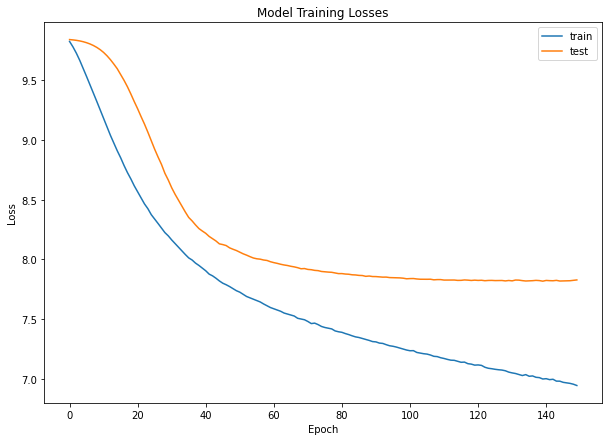

In [ ]:
pd.DataFrame({
    "train": history.history["loss"],
    "test": history.history["val_loss"],
}).plot(figsize=(10,7))

plt.title("Model Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Save the model

In [ ]:
!mkdir data/models

In [ ]:
model.save("data/models/softmax_model_bn_do0.2_e200")

INFO:tensorflow:Assets written to: data/models/softmax_model_bn_do0.2_e200/assets


In [ ]:
model = tf.keras.models.load_model("data/models/softmax_model_bn_do0.2_e200")

In [ ]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 18746)]           0         
_________________________________________________________________
dense_92 (Dense)             (None, 64)                1199744   
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_31 (Batc (None, 64)                256       
_________________________________________________________________
activation_30 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0  

---
---
# 4. Configure the user input in the 'Demo' section
---
---

### Create a colour for each of the artist genres

To make visualisation easier, we assign a random colour to each genre.

In [ ]:
def random_colour():
  return "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])

In [ ]:
# Assign colours to each genre
unique_genres = artists["genre"].unique()
colours  = [random_colour() for _ in range(len(unique_genres))]

genre_colours = pd.DataFrame({
    "genre": unique_genres,
    "colour": colours
})

genre_colours

,genre,colour
0,None,#A67890
1,dark wave,#5FDA98
2,black metal,#19942A
3,gothic black metal,#84366C
4,alternative metal,#0D0E58
...,...,...
2044,armenian folk,#B68652
2045,kurdish pop,#2DC0D8
2046,musica tradicional cubana,#65E2D5
2047,jazz boom bap,#E52DE9


### Create the functions to get a list of recommendations

In [ ]:
def get_artists(predictions: np.ndarray, top=10):
    """
    Takes the raw predictions from a model and returns artist IDs, names, predictions for the top N predictions.
    """

    # If top is negative, return the bottom predicted artists instead
    if top < 0:
        top_idx = predictions.argsort()[:-top]
    else:
        top_idx = predictions.argsort()[::-1][:top]

    top_artists = artists.set_index("artistID").reindex(top_idx)["artistName"]

    return np.asarray(top_artists.index), top_artists.values, predictions[top_idx]

In [ ]:
def get_artist_info(id):
    artist = artists[artists["artistID"] == id].iloc[0]

    if artist["imageUrl"] is None:
        image = "https://icons-for-free.com/iconfiles/png/512/listen+music+song+icon-1320165662165792488.png"
    else:
        image = artist["imageUrl"]


    return artist["artistName"], image, artist["genres"], artist["spotifyUrl"]

To add to the system's explainability, we calculate some extra statistics to display to the user.  

In [ ]:
def get_stat(id1, id2):
  # Returns proportion of people who listen to artist 1 that also listen to artist 2
  num_both = (listening[listening["artistID"].isin([id1, id2])].groupby("userID").count() == 2).sum().iloc[0]
  num_first = len(listening[listening["artistID"] == 51])

  return num_both / num_first

def get_best_stat(ids1, id2):
  # Returns the best artist 1 -> artist 2 statistic out of a list of candidates

  best_stat = None, None, -1
  for id1 in ids1:
    stat = get_stat(id1, id2)

    if stat > best_stat[2]:
      best_stat = id1, id2, stat

  return best_stat

def get_stat_wording(id1, id2, stat):
  name1 = artists[artists["artistID"] == id1].iloc[0]["artistName"]
  name2 = artists[artists["artistID"] == id2].iloc[0]["artistName"]

  return f"{stat:.0%} of people who listen to {name1} also listen to {name2}."

In [ ]:
def get_popularity(id):
  num_listeners = len(listening[listening["artistID"] == id])
  total_time = listening.loc[listening["artistID"] == id, "artistWeight"].sum()
  name = artists[artists["artistID"] == id].iloc[0]["artistName"]

  return f"{num_listeners} users have listened to {name} for a total of {total_time:,} minutes."

To display the recommendations in a user friendly format, we build a grid of HTML elements.  

In [ ]:
def artist_display(id):
  # Creates a list item widget with artist info

  name, img_url, genres, spotify_url = get_artist_info(id)
  img = HTML(f'<img src="{img_url}" width=150 height=150/>')

  # Name heading
  if spotify_url:
    name_html = HTML(f'<h1><a href="{spotify_url}" target="_blank" rel="noopener noreferrer">{name}</a></h1>')
  else:
    name_html = HTML(f'<h1>{name}</h1>')

  # Genres
  if len(genres) == 0:
    genres = ["none"]
  genres_html = HTML(f'<b>Genres:</b> {", ".join(genres[:5])}')

  # Stats
  stat_list = []
  if len(select.value) > 0:
    stat_wording = get_stat_wording(*get_best_stat(select.value, id))
    stat_list.append(stat_wording)

  stat_list.append(get_popularity(id))
  stats_html = HTML(
      "<ul>" +
      "".join(f"<li>{x}</li>" for x in stat_list) +
      "</ul>"
      )

  return HBox([img, 
               VBox([
                name_html,
                genres_html,
                stats_html
              ])])

In [ ]:
def update_list(ids):
  # Updates the recommendation list
  recommend_list.children = list(map(artist_display, ids))

In [ ]:
def calculate_recommendations(b):
  global ids, names, scores

  b.disabled = True
  
  # Build user vector
  vector = np.zeros(num_artists)

  if len(select.value) > 0:
    vector[list(select.value)] = 1
    vector /= vector.sum()

  # Get predictions
  pred = model(vector[None, :]).numpy()[0]

  # Filter out user picked artists
  pred[list(select.value)] = 0

  ids, names, scores = get_artists(pred, 50)

  # Update the recommendations list
  update_list(ids[:5])


  b.disabled = False

---
---
# 5. Demo
---
---

To build a user interface we use IPython widgets. We can show a selectable list of artists for the user to select, and then generate recommendatons at the push of a button.  

In [ ]:
artists_name_id = list(map(tuple, artists[["artistName", "artistID"]].sort_values("artistName").values))

select = SelectMultiple(
    options=artists_name_id, 
    layout=Layout(width="auto"),
    rows=30
)

submit = Button(description="Update Recommendations", layout=Layout(width="auto"))
submit.on_click(calculate_recommendations)

output = Output()

select_box = VBox([
            Label("Select the artists you like (hold ctrl to select many):"),
            select,
            submit,
            output,
], layout=Layout(width="25%"))

recommend_list = VBox([], layout=Layout(width="75%"))

box = HBox([select_box, recommend_list])

In [ ]:
box

### Plot these recommended artists

In [ ]:
# Template for plotting
template = dict(
  layout=go.Layout(
    title=dict(
      x=0.5,
      xanchor="center"
    )
  )
)

In [ ]:
def plot_artists(ids, names, scores):
  genres = artists.set_index("artistID").loc[ids, "genre"].tolist()
  colours = genre_colours.set_index("genre").loc[genres, "colour"].tolist()


  data = pd.DataFrame({"name": names, "weight": scores, "color": colours, "genre": genres, "id": ids})
  fig = go.Figure(go.Bar(dict(
    x=data["name"],
    y=data["weight"],
    marker=dict(
        color=data["color"]
    ),
    hovertemplate=(
      "Artist: %{x}<br>"
      "ID: %{text[1]}<br>"
      "Genre: %{text[0]}<br>"
      "Predicted value: %{y:,.3f} <br>"
    ),
    text=data[["genre", "id"]],
    name=""
  )), layout=dict(
      template=template,
      yaxis=dict(title="Predicted Value", zeroline=True),
      title=dict(text="Artist Recommendations for the Given User"),
  ))

  fig.show()

We can also plot the raw predicted values for the artists. Hover over the bars in the plot for more information.  

In [ ]:
plot_artists(ids, names, scores)